# Sentiment analysis on Reviews given by viewers on IMDB

# The Dataset and The Problem to Solve
> In this notebook, we’ll work with the IMDB dataset containing 50,000 movie reviews, available on Kaggle. The dataset includes two columns—"review" and "sentiment"—which indicate whether a review is positive or negative.

> The purpose of sentiment analysis is to determine the emotional tone or attitude expressed in a text, for example, in a review, comment, or social media post. The mood can be positive or negative. Sentiment analysis can also include determining the strength of sentiment, for example, whether it is strongly positive or weakly positive.

## Importing necessary libraries

In [83]:
import numpy as np
import pandas as pd

import re
import os
import random 
import string, time

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, GRU, Input, Dropout, Embedding, BatchNormalization, Bidirectional, LayerNormalization, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall

from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import precision_recall_curve, f1_score, roc_curve

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

In [2]:
import nltk
nltk.download('stopwords')

nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

## Preparing the data

In [4]:
data = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
data['sentiment'].value_counts(normalize=True)

sentiment
positive    0.5
negative    0.5
Name: proportion, dtype: float64

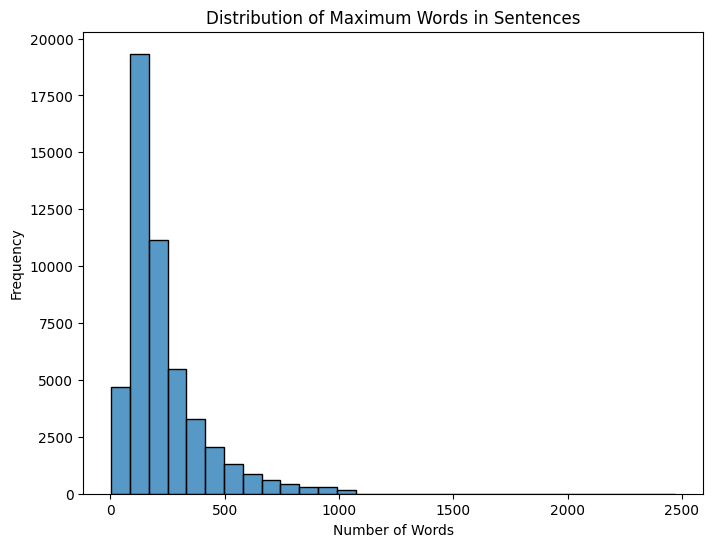

In [6]:
max_words = data['review'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 6))
sns.histplot(max_words, bins=30)
plt.title('Distribution of Maximum Words in Sentences')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [7]:
def remove_HTML(text):
    pattern = re.compile('<.*?>')
    return pattern.sub(r'', text)

def remove_URL(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'', text)

def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

def remove_digits(text):
    return re.sub(r'\d+', '', text)


exclude = string.punctuation

data['review'] = data['review'].apply(remove_HTML)
data['review'] = data['review'].apply(remove_URL)
data['review'] = data['review'].apply(remove_punc)
data['review'] = data['review'].apply(remove_digits)
data['review'] = data['review'].str.lower()

In [8]:
def tokenize(text):
    token = word_tokenize(text)
    return token

# Apply
data['review'] = data['review'].apply(tokenize)

In [9]:
stop_words = set(stopwords.words('english'))

# func for deleting stop words
def remove_stopwords(review):
    return [word for word in review if word not in stop_words]

# apply to review column
data['review'] = data['review'].apply(remove_stopwords)

In [10]:
data.head()

,review,sentiment
0,"[one, reviewers, mentioned, watching, oz, epis...",positive
1,"[wonderful, little, production, filming, techn...",positive
2,"[thought, wonderful, way, spend, time, hot, su...",positive
3,"[basically, theres, family, little, boy, jake,...",negative
4,"[petter, matteis, love, time, money, visually,...",positive


In [11]:
data['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [12]:
# make binary target
data['sentiment'] = data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

## Splitting data into train and test set 

In [13]:
# split into 3 samples
X = data['review']
y = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [14]:
print('Train size: ', X_train.shape[0])
print('Test size: ',  X_test.shape[0])

Train size:  40000
Test size:  10000


In [15]:
print('Train target: ')
print(y_train.value_counts(normalize=True))
print('Test target: ')
print(y_test.value_counts(normalize=True))

Train target: 
sentiment
1    0.5
0    0.5
Name: proportion, dtype: float64
Test target: 
sentiment
0    0.5
1    0.5
Name: proportion, dtype: float64


In [16]:
X_train = np.array(X_train)
X_test  = np.array(X_test)

In [17]:
# create a Tokenizer
tokenizer = Tokenizer(num_words=10000)  # max number of words
tokenizer.fit_on_texts(X_train)

# converting texts into sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# reducing all sequences to the same length
max_len = 150  # max length of sequence
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

## Create a model

In [25]:
# create LSTM model

# fix seed 
os.environ['PYTHONHASHSEED'] = '42' 
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

embedding_dim = 128  # embedding size

model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=embedding_dim, input_length=max_len))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(32, return_sequences=False)))
model.add(Dropout(0.3))
model.add(Dense(units = 32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(0.00001))


# EarlyStopping for val loss
early_stopping_monitor = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=50,  
    mode='min',  
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=1e-9)

history = model.fit(X_train, y_train, 
                    validation_split=0.2,
                    batch_size=128, 
                    epochs=400,
                    callbacks=[early_stopping_monitor, reduce_lr],
                    shuffle = True
                   )

Epoch 1/400
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 92ms/step - accuracy: 0.4977 - loss: 0.6931 - val_accuracy: 0.5021 - val_loss: 0.6931 - learning_rate: 1.0000e-05
Epoch 2/400
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.5057 - loss: 0.6930 - val_accuracy: 0.5364 - val_loss: 0.6920 - learning_rate: 1.0000e-05
Epoch 3/400
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.5365 - loss: 0.6906 - val_accuracy: 0.6369 - val_loss: 0.6548 - learning_rate: 1.0000e-05
Epoch 4/400
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.6641 - loss: 0.6172 - val_accuracy: 0.8251 - val_loss: 0.5346 - learning_rate: 1.0000e-05
Epoch 5/400
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.7761 - loss: 0.5437 - val_accuracy: 0.8413 - val_loss: 0.4715 - learning_rate: 1.0000e-05
Epoch 6/400
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.8101 - loss: 0.4869 - val_accuracy: 0.8434 - val_loss: 0.4300 - learning_rate: 1.0000e-05
Epoch 7/400
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 9

## Model Evaluation

In [84]:
y_pred = model.predict(X_test)
y_pred_rounded = np.round(y_pred)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step


Text(95.72222222222221, 0.5, 'Truth')

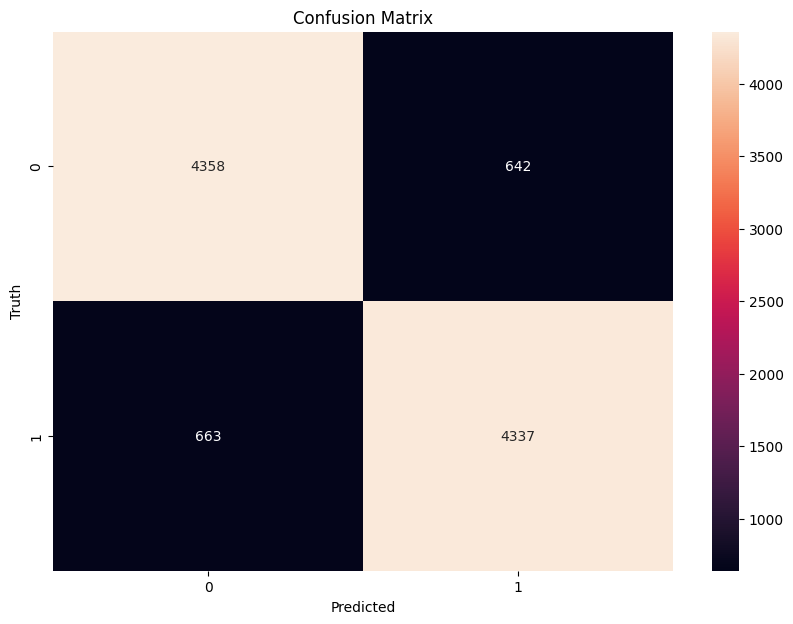

In [26]:
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred_rounded)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [20]:
accuracy_per_class = accuracy_score(y_test, y_pred_rounded)
precision_per_class = precision_score(y_test, y_pred_rounded, average=None)
recall_per_class = recall_score(y_test, y_pred_rounded, average=None)

print('Accuracy: ',  accuracy_per_class)
print('Recall: ',  recall_per_class)
print('Precision: ',  precision_per_class)

Accuracy:  0.8626
Recall:  [0.8962 0.829 ]
Precision:  [0.83976762 0.88872213]


In [55]:
# num of random examples
num_samples = 10
# сhoose random n index
random_indices = np.random.choice(len(X_test), num_samples, replace=False)

X_random_examples = X_test[random_indices]
y_random_target = y_test.reset_index(drop=True)[random_indices]
random_examples_texts = tokenizer.sequences_to_texts(X_random_examples)

In [75]:
print(random_examples_texts[0])

print('actual class: ', y_random_target.iloc[0])

print('prediction: ', model.predict(X_random_examples[0].reshape(-1, X_random_examples.shape[1])))

challenge free one first films saw child also one first vhs tapes owned hadnt seen movie years yesterday decided stick tape watch wow story powerful first time saw think older better values movie value freedom love nature b movie sure one youll remember years especially see child
actual class:  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
prediction:  [[0.978994]]


In [76]:
print(random_examples_texts[2])

print('actual class: ', y_random_target.iloc[2])

print('prediction: ', model.predict(X_random_examples[2].reshape(-1, X_random_examples.shape[1])))

accepted one best teenage comedies seen long time original script talented cast delivers hour half pure tells story high school graduate b gains justin long accepted applied avoid parents disappointment creates fictional attempt fool parents completely creates fake website turns old psychiatric hospital school everything goes smoothly lot accepted students turn friend figure thing others long lead man absolutely brilliant character natural supporting acts outstanding hill short hands maria rory adam glen lewis black uncle humour fresh simple importantly funny right start credits plot develops easy time stop laughing last joke start next along fun movie brings common subject attention ie education usually students movie united school government case united mutual desire go school movie doesnt brand schools wrong shows another way say may sometimes children know better need movie little story great opportunities life wrapped best format possible
actual class:  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [77]:
print(random_examples_texts[8])

print('actual class: ', y_random_target.iloc[8])

print('prediction: ', model.predict(X_random_examples[8].reshape(-1, X_random_examples.shape[1])))

entered first comment film almost five years ago ideas presented movie still seemed mostly fictional indeed could ever longer politics society media running man seem close home following factors mostly absent year running man came present richard character damon puts traditional morality form extreme reality including pain fear part contestants everywhere travel citizens government controlled computer system complete travel passes movie guise national security incestuous government media graphics advanced enough manipulate real film footage digital ben richards image onto stunt double current administration economy wealthy increasing numbers groups big government civil surface nearly every public event regardless origin intent check check maybe movie based stephen king safe im moving switzerland
actual class:  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
prediction:  [[0.96770644]]


In [80]:
print(random_examples_texts[3])

print('actual class: ', y_random_target.iloc[3])

print('prediction: ', model.predict(X_random_examples[3].reshape(-1, X_random_examples.shape[1])))

ok risky move rent flick thought nothing wrong next worst ever seen crappy actors crappy technical output crappy story soundtrack though isnt bad give vote course cats positive surprise far superior actors movie rent buy stay away hope horrible horrible film obscure existence become cult classic definitely deserve recognition
actual class:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
prediction:  [[0.08247001]]


In [91]:
print(random_examples_texts[5])

print('actual class: ', y_random_target.iloc[5])

print('prediction: ', model.predict(X_random_examples[5].reshape(-1, X_random_examples.shape[1])))

hoped show somewhat realistic stroke another mainstream show watched didnt feel characters americas idea terrorism main character doesnt act like passes terrorist beyond neither terrorists managed appear genuine one members blonde white boy would never accepted muslim terrorists real life another member french doesnt quite fit terror movement top terrorists sexual relations white american find strange another stupid american tv show realistic prison break
actual class:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
prediction:  [[0.09136765]]
